## Библиотеки

In [1]:
%config Completer.use_jedi=False
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from os.path import join, exists
from glob import glob
from zipfile import ZipFile
from tqdm.notebook import tqdm
import re

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import cv2

## Датасет

In [80]:
class CatsDogsDataset(torch.utils.data.Dataset):
    
    
    def __init__(self, dataset_path, indices=[], mode='train'):
        self.dataset_path = dataset_path
        self.mode = mode
        self.indices = indices
        
        # Проверки
        assert exists(self.dataset_path), (f'Directory {self.dataset_path} '
                                           'does not exist!')
        assert mode in ['train', 'test', 'val'], 'Impossible mode!'
        
        # Разархивируем картинки и загружаем пути
        if self.mode in ['train', 'val'] and not exists(join(self.dataset_path, 'train_set')):
            assert exists(join(self.dataset_path, 'Cats vs. Dogs.zip')), ('Dataset archive '
                                                                          'does not exist!')
            with ZipFile(join(self.dataset_path, 'Cats vs. Dogs.zip')) as zf:
                zf.extractall(self.dataset_path)
                
        if self.mode in ['train', 'val']:
            self.image_list = np.array(glob(join(
                self.dataset_path, 'training_set', '*', '*.jpg'
            )))[self.indices].tolist()
        else:
            self.image_list = glob(join( self.dataset_path, 'test_set', '*', '*.jpg'))
    
    
    def __getitem__(self, idx): 
        image_path = self.image_list[idx]
        image = cv2.imread(self.image_list[idx], cv2.IMREAD_COLOR)
        category = re.findall('(cat|dog).\d+.jpg', image_path)
        if category[0] == 'cat':
            label = 0
        elif category[0] == 'dog':
            label = 1
             
        # Аугументация
        if self.mode == 'train':
            augument = T.Compose([T.ToPILImage(),
                                  T.Resize((256,256)),
                                  T.RandomHorizontalFlip(p=0.5),
                                  T.RandomRotation(90),
                                  T.ToTensor(),
                                  T.Normalize(mean=(0.485, 0.456, 0.406),
                                              std=(0.229, 0.224, 0.225))
                                 ])
        else:
            augument = T.Compose([T.ToPILImage(),
                                  T.Resize((256,256)),
                                  T.ToTensor(),
                                  T.Normalize(mean=(0.485, 0.456, 0.406),
                                              std=(0.229, 0.224, 0.225))
                                 ])
                
        image = augument(image)
        return label, image
            
        
    def __len__(self):
        return len(self.image_list)
         

## Модель

In [7]:
class CatdogNN(nn.Module):
    def __init__(self):
        super(CatdogNN,self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
            )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        
        self.fc = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(1024, 2)
        )
               
    def forward(self, inp):
        out = self.conv1(inp)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [8]:
def fit_nn(epochs, lr, model, train_loader, val_loader, criterion, optimizer,
           device, load=True, checkpoint_path='./cat_dog.pth', save_interval=5):
    
    # Инициализация
    history = {'train': {'acc':[], 'loss':[]}, 'val': {'acc':[], 'loss':[]}}
    curr_epoch = 0
    
    # Загружаем чекпоинт
    if exists(checkpoint_path) and load:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = checkpoint['history']
        curr_epoch = checkpoint['epoch']
        print('Checkpoint loaded')
    
    # Главный цикл
    for epoch in range(curr_epoch + 1, curr_epoch + epochs + 1):
        train_epoch_acc, train_epoch_loss = 0, 0
        
        # Тренировочная фаза 
        model.train()
        for label, image in tqdm(train_loader, leave=False):
            label = label.to(device)
            image = image.to(device)
            
            train_out = model(image)
            train_loss = criterion(train_out, label)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_acc = (train_out.argmax(dim=1) == label).float().mean()
            train_epoch_acc += train_acc/len(train_loader)
            train_epoch_loss += train_loss/len(train_loader)
        
        # Валидационная фаза
        with torch.no_grad():
            val_epoch_acc, val_epoch_loss = 0, 0
            
            for label, image in tqdm(val_loader, leave=False):
                label = label.to(device)
                image = image.to(device)

                val_out = model(image)
                val_loss = criterion(val_out,label)

                val_acc = (val_out.argmax(dim=1) == label).float().mean()
                val_epoch_acc += val_acc/ len(val_loader)
                val_epoch_loss += val_loss/ len(val_loader)
        
        # Сохранить и показать промежуточные результаты
        history['train']['acc'].append(train_epoch_acc)
        history['train']['loss'].append(train_epoch_loss)
        history['val']['acc'].append(val_epoch_acc)
        history['val']['loss'].append(val_epoch_loss)
        print(f'Epoch {epoch} | Train: accuracy = {train_epoch_acc:.4f}, '
              f'loss = {train_epoch_loss:.4f} '
              f'| Validation: accuracy = {val_epoch_acc:.4f}, '
              f'loss = {val_epoch_loss:.4f}')
    
        # Чекпоинт
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
            }, checkpoint_path)
    
    return history

## Визуализация

In [45]:
def visualize_imgs(dataset, num_imgs, cols, size, model=None):
    indices = np.random.random_integers(0, len(dataset), num_imgs)
    fig, ax = plt.subplots(num_imgs // cols + int(num_imgs % cols != 0),
                           cols, figsize=size)
    mapping = {0: 'cat', 1: 'dog'}
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for n, idx in enumerate(indices):
        label, image = dataset[idx]
        if model:
            label = model(image[None, :, :, :].to(DEVICE)).argmax(dim=1).item()
        image = ((image * std[:, None, None] + mean[:, None, None])
                 * 255).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax[n//cols, n%cols].imshow(image)
        ax[n//cols, n%cols].axis('off')
        ax[n//cols, n%cols].title.set_text(mapping[label])
    if num_imgs % cols != 0:
        for i in range(cols - num_imgs % cols):
            fig.delaxes(ax[-1][cols-i-1])
    plt.tight_layout()

In [9]:
ds_path = './data/'
train_ind, val_ind = train_test_split(range(8000), test_size=0.2)
train_set = CatsDogsDataset(ds_path, mode='train', indices=train_ind)
train_full_set = CatsDogsDataset(ds_path, mode='train', indices=range(8000))
val_set = CatsDogsDataset(ds_path, mode='val', indices=val_ind)
test_set = CatsDogsDataset(ds_path, mode='test')

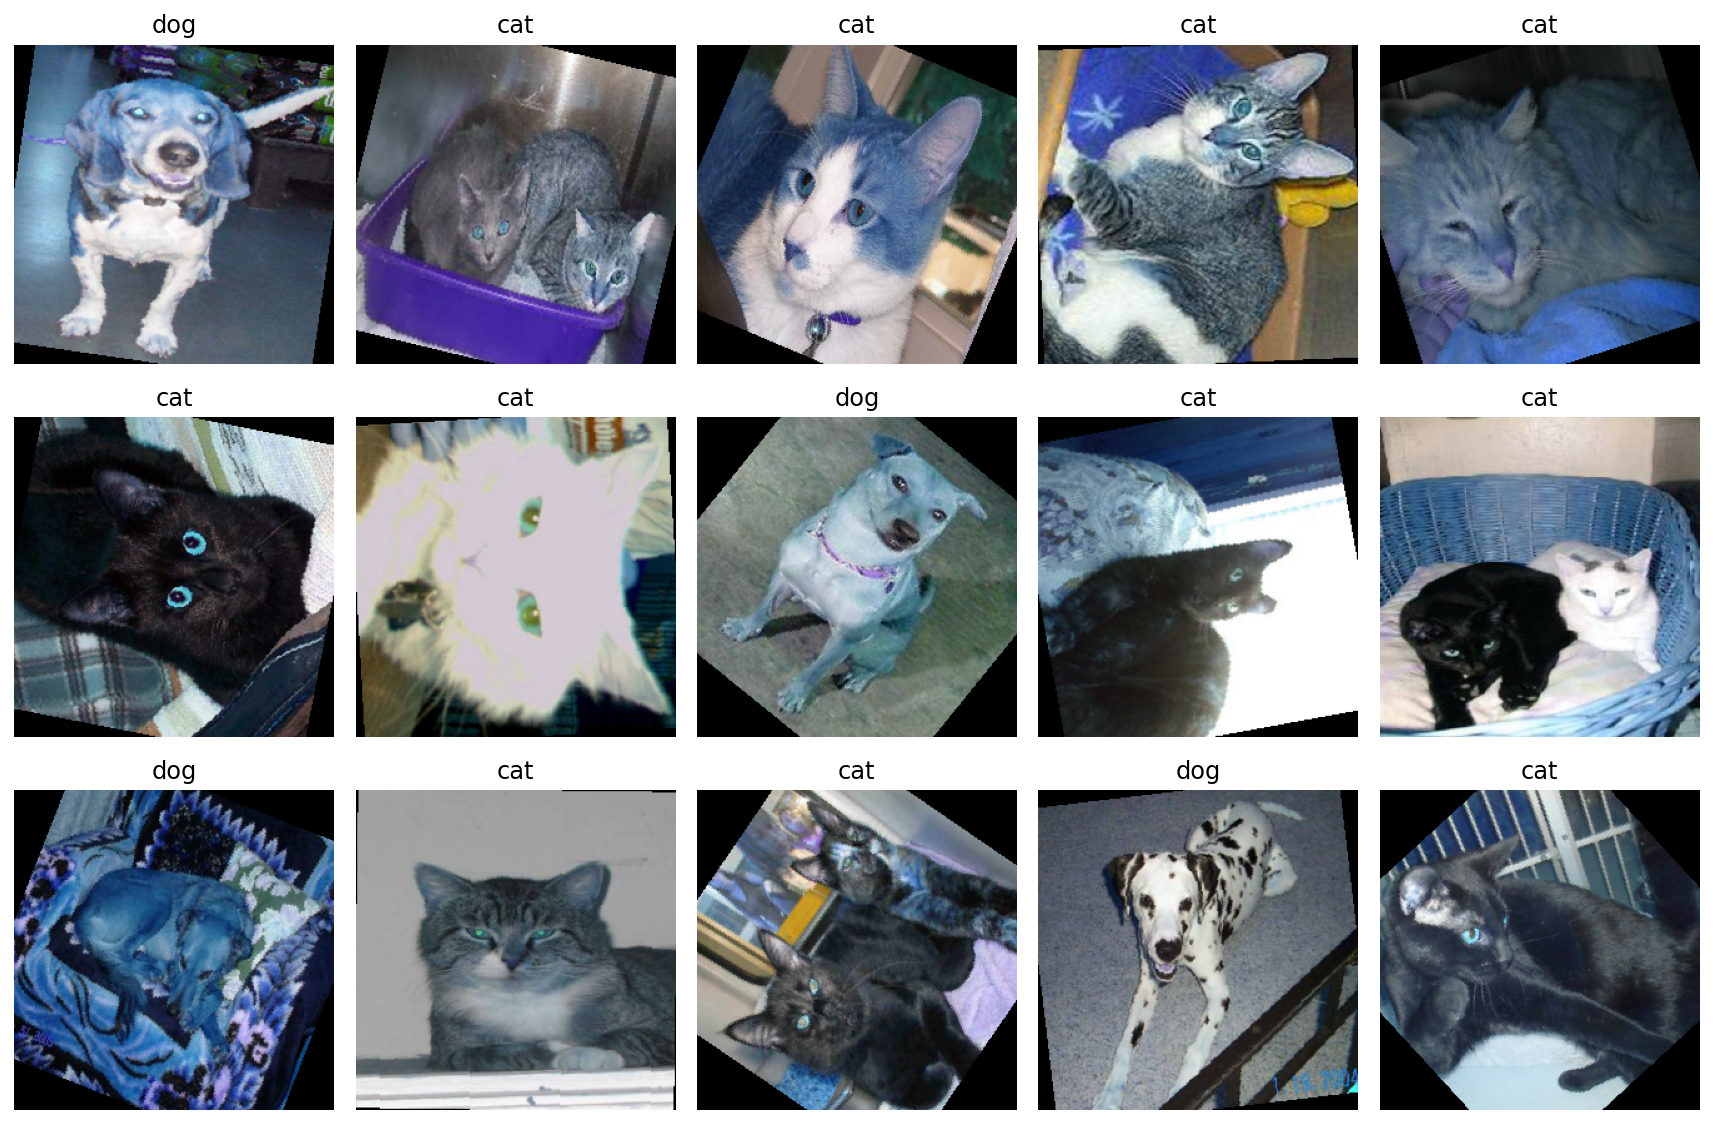

In [10]:
visualize_imgs(train_set, 15, 5, (12, 8))

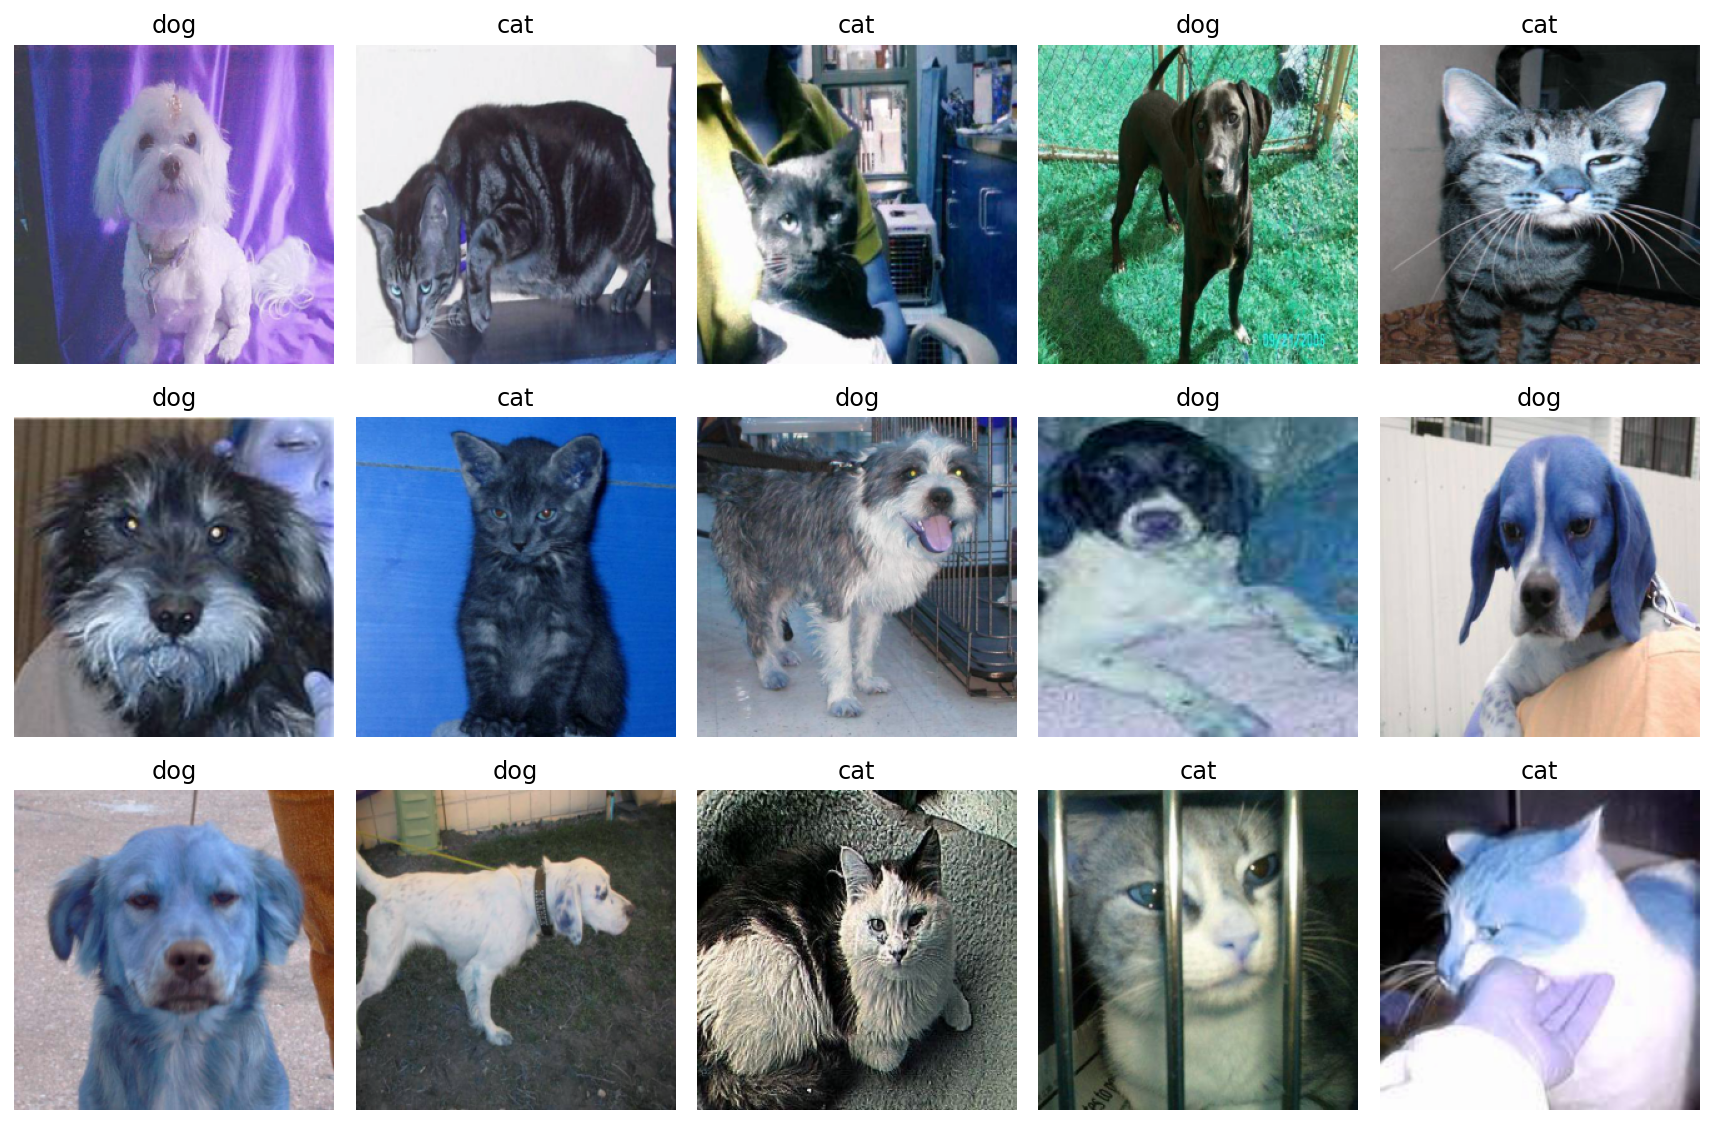

In [11]:
visualize_imgs(test_set, 15, 5, (12, 8))

## Обучение

In [15]:
LR = 0.001 
BATCH_SIZE = 100
NUM_EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size=BATCH_SIZE, shuffle=True)
train_full_loader = torch.utils.data.DataLoader(dataset = train_full_set,
                                           batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                         batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size=BATCH_SIZE, shuffle=True)

In [17]:
model = CatdogNN().to(DEVICE)
optimizer = torch.optim.Adam(params = model.parameters(),lr=LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
res = fit_nn(NUM_EPOCHS, LR, model, train_loader, val_loader, criterion, optimizer, DEVICE)

In [13]:
res_final = fit_nn(NUM_EPOCHS, LR, model, train_full_loader, test_loader, criterion, optimizer, DEVICE)

## Визуализация процесса обучения

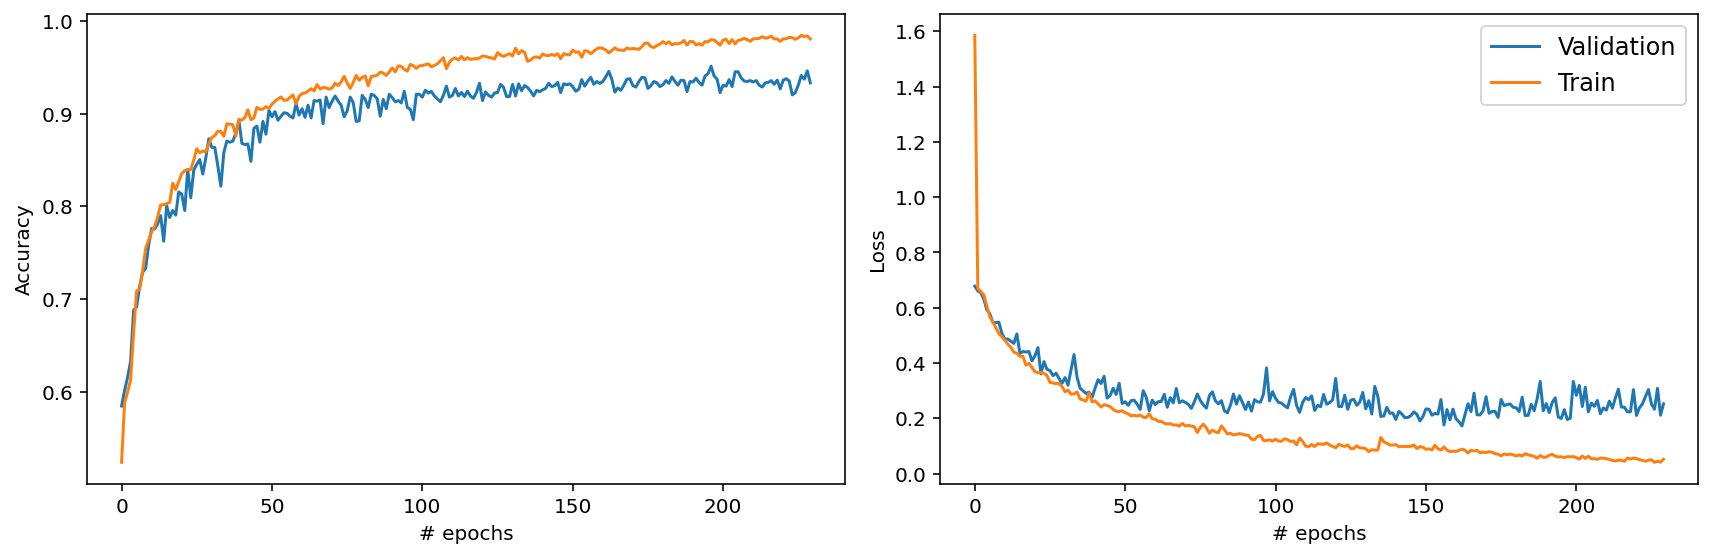

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot([x.item() for x in history['val']['acc']], label='Validation')
ax[0].plot([x.item() for x in history['train']['acc']], label='Train')
ax[1].plot([x.item() for x in history['val']['loss']], label='Validation')
ax[1].plot([x.item() for x in history['train']['loss']], label='Train')
ax[0].set_xlabel('# epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_xlabel('# epochs')
ax[1].set_ylabel('Loss')
plt.legend(fancybox=True, fontsize='large')
plt.tight_layout();
plt.savefig('img/training.jpg');

## Инференс модели

In [18]:
model = CatdogNN().to(DEVICE)
checkpoint = torch.load('cat_dog.pth')
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
curr_epoch = checkpoint['epoch']
print('Checkpoint loaded')

Checkpoint loaded


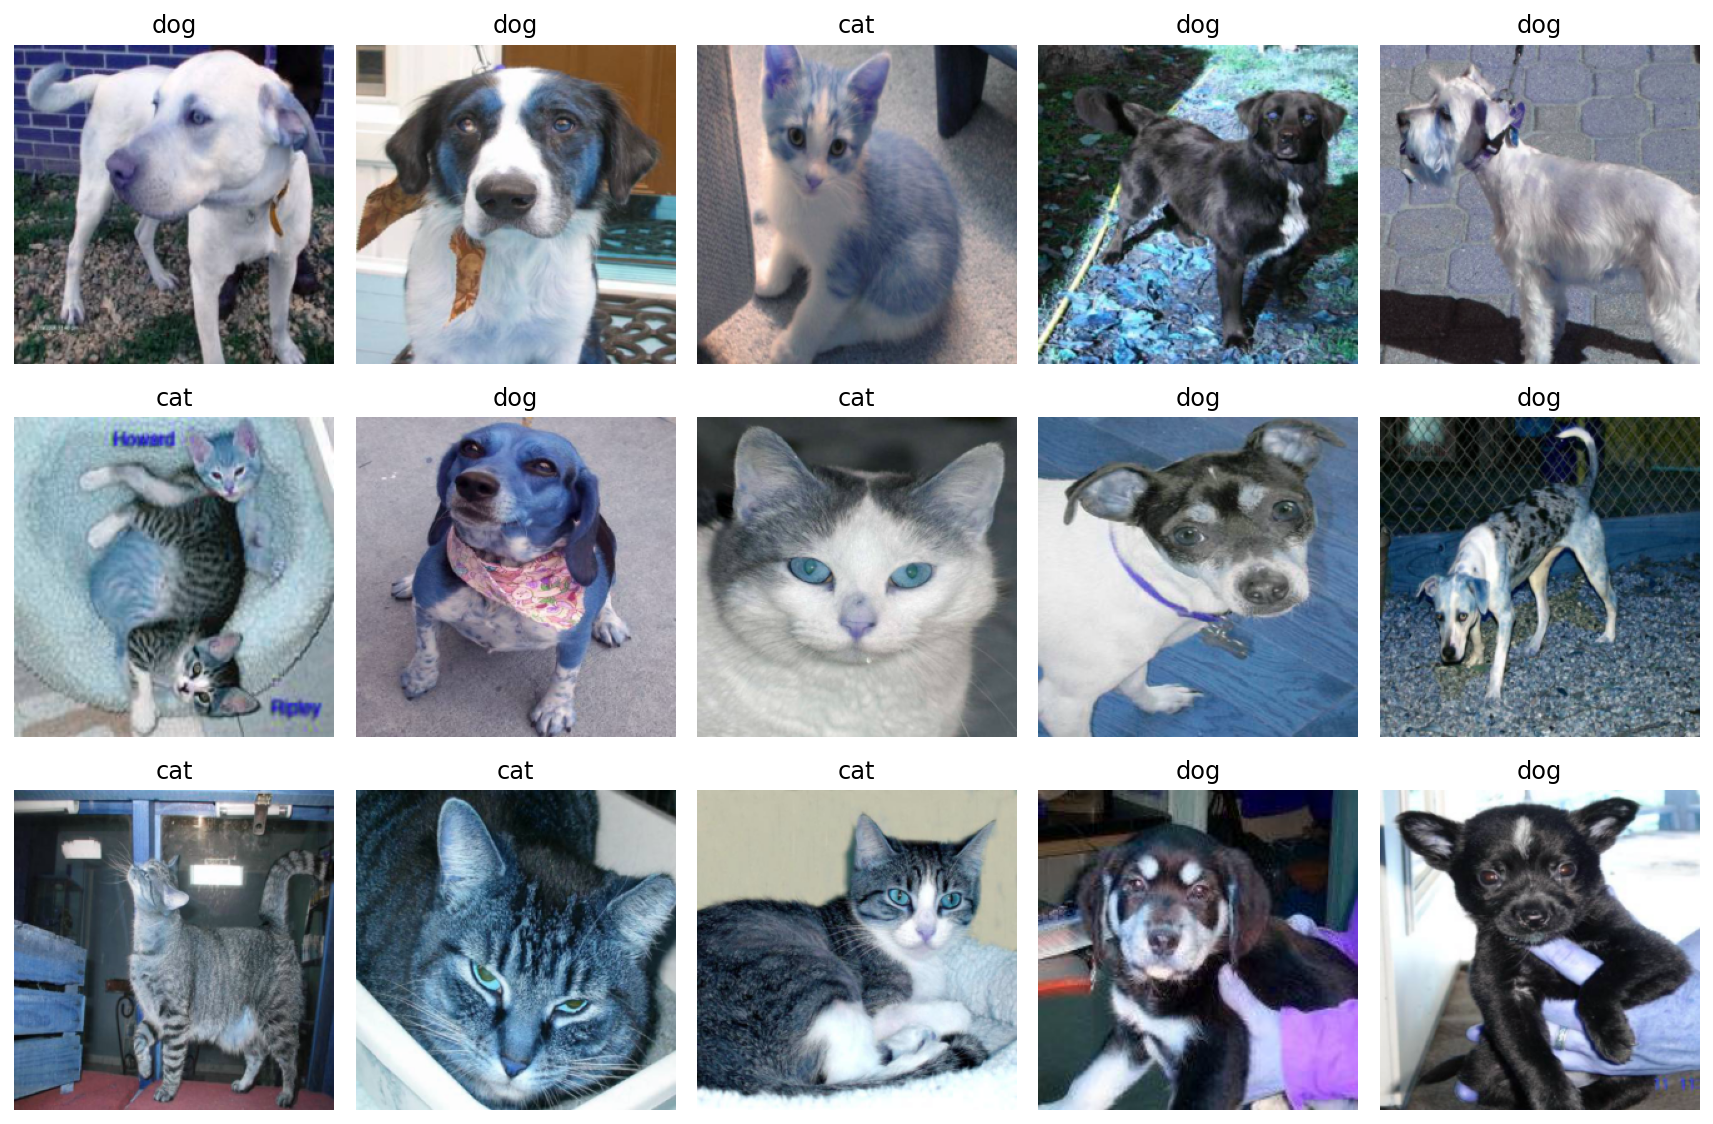

In [81]:
test_set = CatsDogsDataset(ds_path, mode='test')
visualize_imgs(test_set, 15, 5, (12, 8), model=model)
plt.savefig('img/infer1.jpg')